# Mean profiles from CNV files

In [86]:
import unisacsi.Ocean as Oc
#import unisacsi.Meteo as Met
#from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo
import scipy.interpolate as interp

In [87]:
def compute_mean(CTD, variable, stationnames):
    CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD, stationnames,interp_opt=0)
    df = pd.DataFrame(CTD_i[variable],index=Z
                    ,columns=stationnames
                   )
    df = df[1:]
    df_mean = df.mean(axis=1)
    
    return df, df_mean

In [88]:
def plot_profiles(df, df_mean, ax):
    ax.plot(df, df.index, color='Gray', alpha=.5)
    ax.plot(df_mean, df_mean.index, lw=2)

    ax.invert_yaxis()

In [89]:
def smooth_profile(df_mean, mld, window=5):
    mixed = df_mean[:mld].mean()
    df_smooth = df_mean.rolling(window=window, center=True).mean()
    
    df_smooth[:mld] = mixed
    
    return df_smooth

In [90]:
def create_initial_ocean(depth, T_mean, S_mean, depth_new):
    interpolater = interp.interp1d(depth, T_mean, fill_value = "extrapolate")
    T_new = interpolater(depth_new)
    
    interpolater = interp.interp1d(depth, S_mean, fill_value = "extrapolate")
    S_new = interpolater(depth_new)

    data = {'depth': model_depth, 'temp':T_new, 'salinity':S_new}
    dataFrame = pd.DataFrame(data)
    return dataFrame

In [91]:
# path to cnv-files. Should be on the format Sta0001.cnv (Sta followed by four digits)
path_data = '../../data/CTD/Adventfjorden/221103/'

In [92]:
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

In [18]:
# print(CTD[stations[0]].keys()) # displays variables saved at first (each) station

dict_keys(['P', 'T', 'C', 'OX', 'S', 'SIGTH', 'Cs', 'sbe_model', 'gps_datetime', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'filename', 'dnum', 'LAT', 'LON', 'z', 'BottomDepth', 'SA', 'CT', 'st', 'unis_st'])


3.575
3.5724201992566056


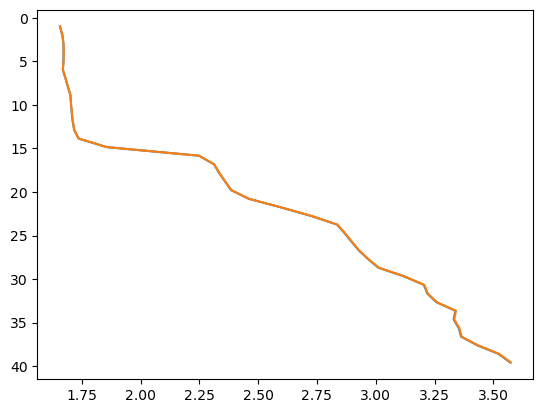

In [93]:
# Converting in-situ temperature to potential temperature 

for station in stations:
    T = CTD[station]['T']
    S = CTD[station]['S']
    P = CTD[station]['P']
    z = CTD[station]['z']
    
    # calculate potential temperature
    PT = gsw.conversions.pt0_from_t(S, T, P)
    CTD[station]['PT'] = PT


print(T[-1])
print(PT[-1])
plt.figure()
plt.plot(PT,-z)
plt.plot(T,-z)
plt.gca().invert_yaxis()

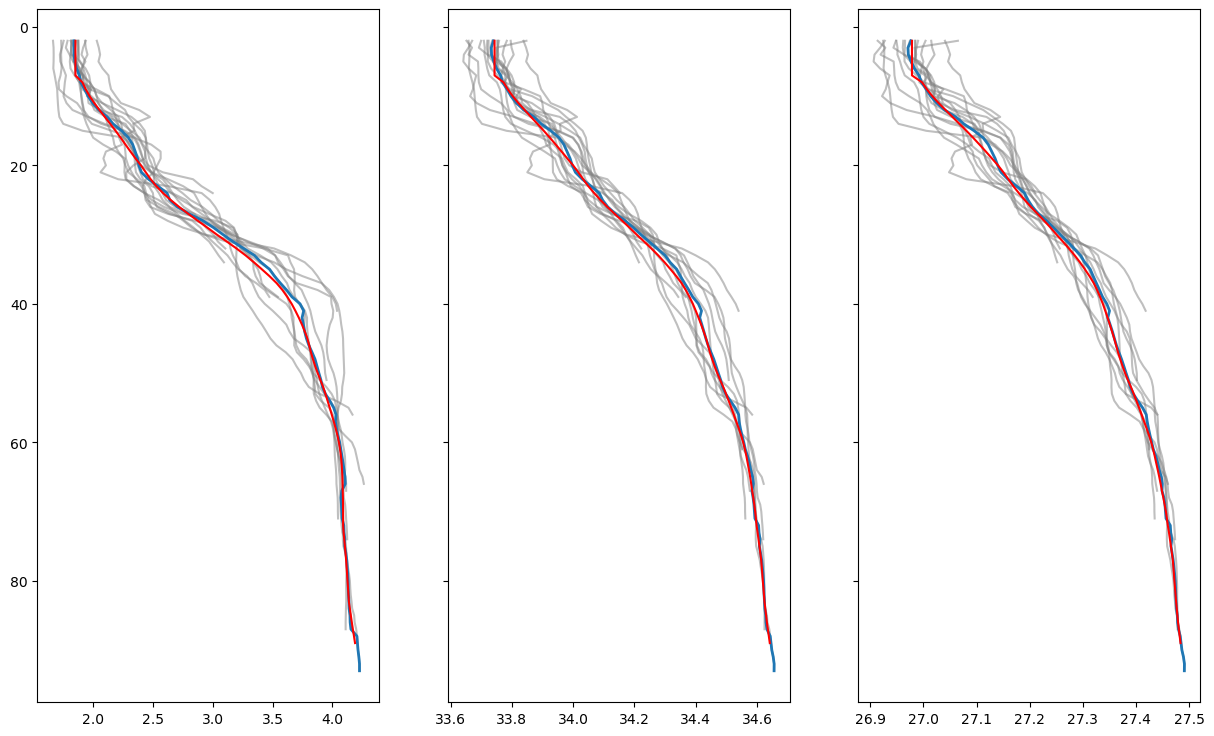

In [7]:
window = 10
mld=7

dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')

In [62]:
dfT_smooth

1.989480     1.854287
2.989484     1.854287
3.989488     1.854287
4.989491     1.854287
5.989495     1.854287
               ...   
88.989799    4.189041
89.989802         NaN
90.989806         NaN
91.989810         NaN
92.989813         NaN
Length: 92, dtype: float64

In [57]:
dfT_smooth.values[0]

1.854287326535264

[1.85428733 1.85428733 1.85428733 1.85428733 1.91246835 1.97308637
 2.05544427 2.14548467 2.2321283  2.31435118 2.40169799 2.48294883
 2.58684436 2.72096982 2.87672537 3.03581258 3.19999974 3.34576755
 3.47529448 3.58302154 3.66021975 3.71977352 3.76998182 3.80647619
 3.83790193 3.87727137 3.92258364 3.95997944 3.99482656 4.02772784
 4.05438212 4.07151438 4.08052298 4.08516971 4.08779075 4.08927479
 4.08963518 4.09902633 4.10956447 4.11854581 4.12606291 4.1340199
 4.14569784 4.16213477 4.18024892        nan        nan]
[33.74363712 33.74363712 33.74363712 33.74363712 33.7729689  33.80314521
 33.84216802 33.88387532 33.92442385 33.9626879  34.00021731 34.03301601
 34.06890184 34.11198964 34.16036177 34.20760033 34.25546168 34.29864893
 34.33674332 34.36776479 34.39076844 34.409324   34.4261001  34.44020219
 34.45390661 34.47034457 34.48981711 34.50766153 34.52440181 34.54060156
 34.55492381 34.56541912 34.57373928 34.58110859 34.58784995 34.59403799
 34.59863119 34.60484267 34.61079787 

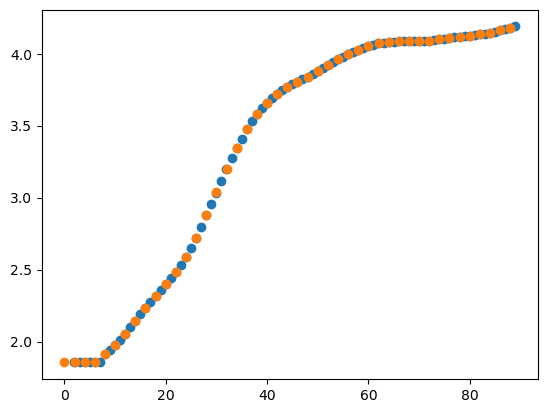

In [71]:
# create file with initial ocean conditions (depth, meanT, meanS)
model_depth = np.arange(0,round(dfT_smooth.index[-1]),2)

# print(model_depth)
T_intp = interp.interp1d(dfT_smooth.index, dfT_smooth.values, fill_value = "extrapolate")
T_new = T_intp(model_depth)
print(T_new)
S_intp = interp.interp1d(dfS_smooth.index, dfS_smooth.values, fill_value = "extrapolate")
S_new = S_intp(model_depth)
print(S_new)

plt.figure()
plt.scatter(dfT_smooth.index, dfT_smooth.values)
plt.scatter(model_depth, T_new )

data = {'depth': model_depth, 'temp':T_new, 'salinity':S_new}
dataFrame = pd.DataFrame(data)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221103.csv")


In [85]:
# create file with initial ocean conditions (depth, meanT, meanS)
dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
print(dataFrame_T)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221103.csv")

    depth      temp   salinity
0       0  2.359237  33.997124
1       2  2.359237  33.997124
2       4  2.359237  33.997124
3       6  2.359237  33.997124
4       8  2.388472  34.005924
5      10  2.422906  34.016211
6      12  2.463723  34.028356
7      14  2.520653  34.044732
8      16  2.587736  34.063904
9      18  2.662657  34.085660
10     20  2.746140  34.109747
11     22  2.836033  34.135117
12     24  2.929898  34.161772
13     26  3.022147  34.189220
14     28  3.105347  34.214872
15     30  3.181279  34.238513
16     32  3.247172  34.259799
17     34  3.298708  34.277831
18     36  3.334805  34.291537
19     38  3.358331  34.301655
20     40  3.371624  34.308984
21     42  3.376470  34.314042
22     44  3.388276  34.319622
23     46  3.408634  34.326471
24     48  3.428996  34.333608
25     50  3.453327  34.340766
26     52  3.482674  34.348935
27     54  3.509363  34.357072
28     56  3.536958  34.365590
29     58  3.574427  34.376801
30     60  3.625561  34.391276
31     6

In [73]:
path_data = '../../data/CTD/Adventfjorden/221031/'
# Read in files
CTD = Oc.read_CTD(path_data)
stations = [f'{i}' for i in CTD.keys()]

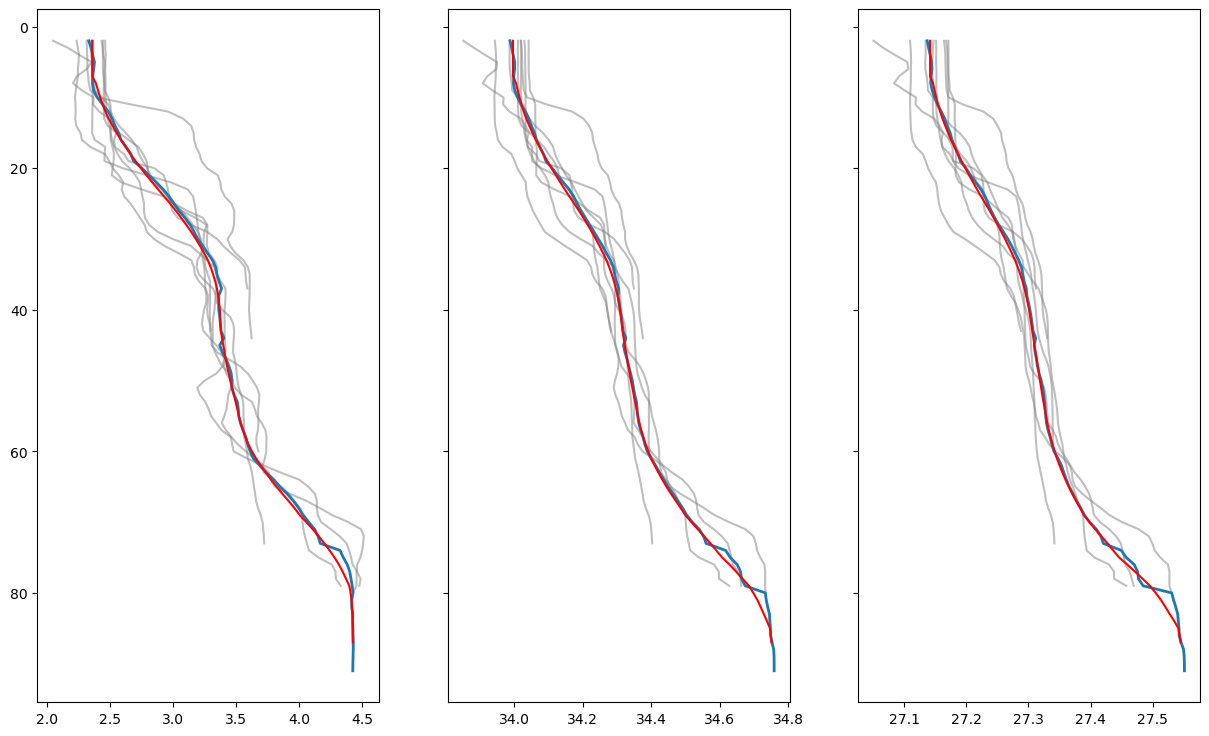

In [74]:
dfT, dfT_mean = compute_mean(CTD, 'T', stations)
dfS, dfS_mean = compute_mean(CTD, 'S', stations)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', stations)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')

[2.35923731 2.35923731 2.35923731 2.35923731 2.38847222 2.42290575
 2.46372312 2.52065287 2.58773647 2.66265685 2.74613974 2.83603347
 2.92989758 3.02214707 3.10534658 3.18127922 3.2471716  3.29870754
 3.33480466 3.35833096 3.37162418 3.3764704  3.38827633 3.40863361
 3.42899585 3.45332723 3.48267408 3.50936252 3.53695787 3.57442734
 3.62556068 3.69506589 3.77681128 3.86713684 3.96195878 4.05714426
 4.15521705 4.24147614 4.31551573 4.37171659 4.40766442 4.41989865
 4.42447585 4.42511992        nan        nan        nan]
[33.99712448 33.99712448 33.99712448 33.99712448 34.00592426 34.01621109
 34.02835602 34.04473193 34.06390439 34.08566025 34.10974652 34.13511736
 34.16177226 34.18921998 34.21487177 34.23851291 34.25979855 34.27783072
 34.29153712 34.30165522 34.30898366 34.31404245 34.31962153 34.32647108
 34.33360755 34.34076563 34.34893491 34.35707244 34.36559014 34.37680126
 34.39127602 34.41008039 34.43233735 34.45763713 34.48564669 34.51721251
 34.55406201 34.58958326 34.62791172

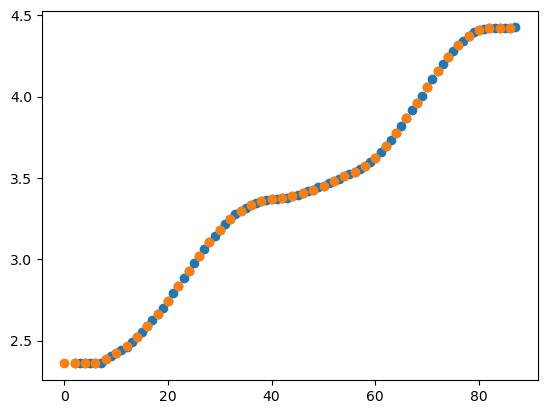

In [75]:
T_intp = interp.interp1d(dfT_smooth.index, dfT_smooth.values, fill_value = "extrapolate")
T_new = T_intp(model_depth)
#print(T_new)
S_intp = interp.interp1d(dfS_smooth.index, dfS_smooth.values, fill_value = "extrapolate")
S_new = S_intp(model_depth)
#print(S_new)

#plt.figure()
#plt.scatter(dfT_smooth.index, dfT_smooth.values)
#plt.scatter(model_depth, T_new )

data = {'depth': model_depth, 'temp':T_new, 'salinity':S_new}
dataFrame = pd.DataFrame(data)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221031.csv")

In [ ]:
# create file with initial ocean conditions (depth, meanT, meanS)
dataFrame = create_initial_ocean(dfT_smooth.index, dfT_smooth.values, dfS_smooth.values, model_depth)
print(dataFrame_T)
dataFrame.to_csv("../../data/CTD_processed/mean_profile_221031.csv")